In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import interpolate
import seaborn as sns
import copy
from copy import deepcopy
import geopandas as gpd
from matplotlib import rcParams

# Set up the aesthetics for the plot
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 12

root_path = os.path.join(os.path.dirname(os.getcwd()), 'FuelPoverty_data')

consider_upfrontcost = True
gov = True
rate = 7

In [2]:
if not consider_upfrontcost:
    All_fp_estimation_dict2019 = np.load(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_dict2019.npy"), allow_pickle=True).item()
    All_fp_estimation_dict2022 = np.load(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_dict2022.npy"), allow_pickle=True).item()
    All_fp_estimation_HP_dict2019 = np.load(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_HP_dict2019.npy"), allow_pickle=True).item()
    All_fp_estimation_HP_dict2022 = np.load(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_HP_dict2022.npy"), allow_pickle=True).item()
else:
    All_fp_estimation_dict2019 = np.load(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_dict2019_rate{rate}{'_gov' if gov else ''}.npy"), allow_pickle=True).item()
    All_fp_estimation_dict2022 = np.load(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_dict2022_rate{rate}{'_gov' if gov else ''}.npy"), allow_pickle=True).item()
    All_fp_estimation_HP_dict2019 = np.load(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_HP_dict2019_rate{rate}{'_gov' if gov else ''}.npy"), allow_pickle=True).item()
    All_fp_estimation_HP_dict2022 = np.load(os.path.join(os.getcwd(), "data_for_plot", f"All_fp_estimation_HP_dict2022_rate{rate}{'_gov' if gov else ''}.npy"), allow_pickle=True).item()

map_df = gpd.read_file(os.path.join(os.getcwd(), "data_for_plot", f"filtered_map.shp"))

In [3]:
def ordering_fp_res_as_mapdf(map_df, All_fp_estimation_dict):
    res = []
    for regname in map_df["RegName"]:
        if regname in All_fp_estimation_dict:
            res.append(All_fp_estimation_dict[regname])
        ## we have so many elseif as their is slightly mismatch between LA names in different dataset.
        ## using la code is a smarter option, but due to the limited number of outliers, we use a brute force way
        elif regname == "City of Edinburgh":
            res.append(All_fp_estimation_dict["Edinburgh, City of"])
        elif regname == "Yorkshire and The Humber":
            res.append(All_fp_estimation_dict["Yorkshire and the Humber"])
        elif regname == "East of England":
            res.append(All_fp_estimation_dict["East"])
        elif regname == "Vale of Glamorgan":
            res.append(All_fp_estimation_dict["The Vale of Glamorgan"])
        else:
            print(regname)

    res = np.array(res)
    fp_res_df = pd.DataFrame(data=res.reshape([-1, 1]), columns=["fp_rate"])
    return fp_res_df

fp_res_df_2019 = ordering_fp_res_as_mapdf(map_df, All_fp_estimation_dict2019)
fp_res_df_2022 = ordering_fp_res_as_mapdf(map_df, All_fp_estimation_dict2022)

fp_res_HP_df_2019 = ordering_fp_res_as_mapdf(map_df, All_fp_estimation_HP_dict2019)
fp_res_HP_df_2022 = ordering_fp_res_as_mapdf(map_df, All_fp_estimation_HP_dict2022)

fp_res_df_dict = {2019:fp_res_df_2019, 2022:fp_res_df_2022}
fp_res_HP_df_dict = {2019:fp_res_HP_df_2019, 2022:fp_res_HP_df_2022}

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_884188\3905112466.py:30: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


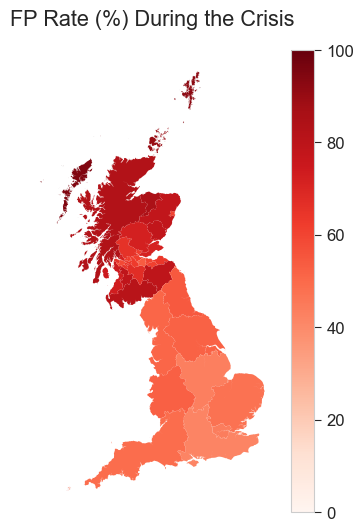

In [27]:
## FP estimation
import matplotlib.cm as cm
from PIL import Image
import io

plt.rcParams.update(
    {
        "lines.markersize": 10,  # Big points
        "font.size": 13,  # Larger font
        "xtick.major.size": 5.0,  # Bigger xticks
        "ytick.major.size": 5.0,  # Bigger yticks
    }
)

price_year = 2022
map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(fp_res_df_dict[price_year].reset_index(drop=True))

fig, ax = plt.subplots(figsize = [4, 6])
cmap = "Reds"
# vmin, vmax = 0.5*fp_res_df_dict[2019].min().item(), fp_res_df_dict[2022].max().item()
vmin, vmax = 0, 100
map_and_res_df.plot(column="fp_rate", cmap=cmap, ax = ax, legend=False, vmin =vmin, vmax = vmax, linewidth = 0, rasterized=True)

# Create a ScalarMappable object
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Set an empty array to ensure proper mapping

# Add colorbar with ticks
cbar = plt.colorbar(sm)
cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Set the ticks to the extreme values
# cbar.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])  # Set the tick labels

year_dict = {2022 :'During the Crisis', 2019: 'Pre-crisis'}

ax.axis("off")
plt.title(f"FP Rate (%) {year_dict[price_year]}")

plt.savefig(os.path.join(os.getcwd(), "figures", f"fp_geomap_{price_year}.pdf"), dpi = 3000)
# plt.show()

del map_and_res_df

In [8]:
vmin

0

## Heatmap for FP Reduction

### Year 2019

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_884188\486346733.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


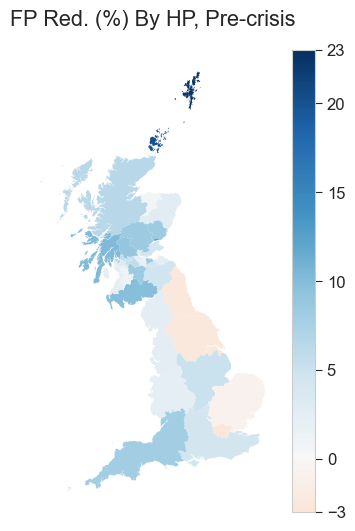

In [9]:
from matplotlib import colors


# specify show absolute or relative difference
Absolute_diff = False

fig, ax = plt.subplots(figsize = [4,6])

price_year = 2019

########################

if Absolute_diff:
    fp_diff_df = pd.DataFrame(data = fp_res_df_dict[price_year].values - fp_res_HP_df_dict[price_year].values, columns = ["fp_diff"])
else:
    fp_diff_df = pd.DataFrame(data = 100*(fp_res_df_dict[price_year].values - fp_res_HP_df_dict[price_year].values) / fp_res_df_dict[price_year].values, columns = ["fp_diff"])

map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(fp_diff_df.reset_index(drop=True))

vmin, vmax = 0.5*min(fp_diff_df.values).item(), max(fp_diff_df.values).item()
vmin, vmax = -3, 23
cmap = "RdBu"
# cmap = "bwr_r"
# cmap = "seismic_r"

# get truncated colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap(cmap)
new_cmap = truncate_colormap(cmap, 0.5+(vmin / vmax * 0.5), 1)

map_and_res_df.plot(column="fp_diff", cmap=new_cmap, ax = ax, legend=False, vmin =vmin, vmax = vmax, linewidth = 0, rasterized=True)

# Create a ScalarMappable object
sm = cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Set an empty array to ensure proper mapping

# Add colorbar with ticks
cbar = plt.colorbar(sm)
cbar.set_ticks([-3, 0, 5, 10, 15, 20, 23])  # Set the ticks to the extreme values

ax.axis("off")
ax.set_title(f"FP Red. (%) By HP, {year_dict[price_year]}")


del map_and_res_df

# plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", f"fp_diff_geomap_{price_year}.pdf"), dpi = 3000)
plt.show()

### Year 2022

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_884188\2159901522.py:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


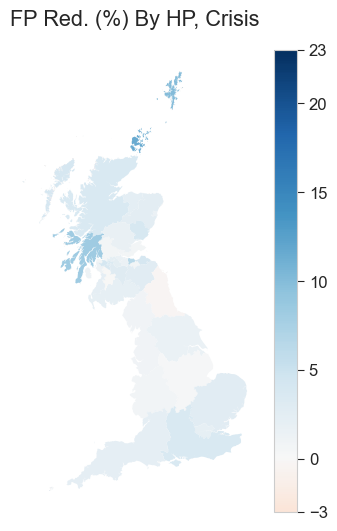

In [10]:
fig, ax = plt.subplots(figsize = [4,6])

price_year = 2022

########################

if Absolute_diff:
    fp_diff_df = pd.DataFrame(data = fp_res_df_dict[price_year].values - fp_res_HP_df_dict[price_year].values, columns = ["fp_diff"])
else:
    fp_diff_df = pd.DataFrame(data = 100*(fp_res_df_dict[price_year].values - fp_res_HP_df_dict[price_year].values) / fp_res_df_dict[price_year].values, columns = ["fp_diff"])

map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(fp_diff_df.reset_index(drop=True))

vmin, vmax = 0.5*min(fp_diff_df.values).item(), max(fp_diff_df.values).item()
vmin, vmax = -3, 23
cmap = "RdBu"
# cmap = "bwr_r"
# cmap = "seismic_r"

# get truncated colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap(cmap)
new_cmap = truncate_colormap(cmap, 0.5+(vmin / vmax * 0.5), 1)

map_and_res_df.plot(column="fp_diff", cmap=new_cmap, ax = ax, legend=False, vmin =vmin, vmax = vmax, linewidth = 0, rasterized=True)

# Create a ScalarMappable object
sm = cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Set an empty array to ensure proper mapping

# Add colorbar with ticks
cbar = plt.colorbar(sm)
cbar.set_ticks([-3, 0, 5, 10, 15, 20, 23])  # Set the ticks to the extreme values

ax.axis("off")
ax.set_title(f"FP Red. (%) By HP, {year_dict[price_year]}")


del map_and_res_df

# plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", f"fp_diff_geomap_{price_year}.pdf"), dpi = 3000)
plt.show()

## Plot for Cost Reduction

In [11]:
### plot for cost reduction
if not consider_upfrontcost:
    df_cost_2019 = pd.read_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost2019.csv"))
    df_cost_2022 = pd.read_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost2022.csv"))

    df_cost_HP_2019 = pd.read_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost_HP2019.csv"))
    df_cost_HP_2022 = pd.read_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost_HP2022.csv"))
else:

    df_cost_2019 = pd.read_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost2019_rate{rate}{'_gov' if gov else ''}.csv"))
    df_cost_2022 = pd.read_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost2022_rate{rate}{'_gov' if gov else ''}.csv"))

    df_cost_HP_2019 = pd.read_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost_HP2019_rate{rate}{'_gov' if gov else ''}.csv"))
    df_cost_HP_2022 = pd.read_csv(os.path.join(os.getcwd(), "data_for_plot", f"df_cost_HP2022_rate{rate}{'_gov' if gov else ''}.csv"))

df_cost_re_2019 = df_cost_2019.copy()
df_cost_re_2019["energy_cost_re"] = (df_cost_2019["energy_cost"] - df_cost_HP_2019["energy_cost"]) / df_cost_2019["energy_cost"] * 100
dict_cost_re_2019 = {}

for reg in df_cost_re_2019["RegName"].unique():
    df_sub = df_cost_re_2019[df_cost_re_2019['RegName'] == reg]
    df_sub_cost = df_cost_2019[df_cost_2019['RegName'] == reg]
    # weighted average
    res = np.sum(df_sub["energy_cost_re"].values * df_sub["weight"].values) / np.sum(df_sub['weight'].values)

    dict_cost_re_2019[reg] = res

df_cost_re_2022 = df_cost_2022.copy()
df_cost_re_2022["energy_cost_re"] = (df_cost_2022["energy_cost"] - df_cost_HP_2022["energy_cost"]) / df_cost_2022["energy_cost"] * 100

dict_cost_re_2022 = {}
for reg in df_cost_re_2022["RegName"].unique():
    df_sub = df_cost_re_2022[df_cost_re_2022['RegName'] == reg]
    df_sub_cost = df_cost_2022[df_cost_2022['RegName'] == reg]
    # weighted average
    res = np.sum(df_sub["energy_cost_re"].values * df_sub["weight"].values) / np.sum(df_sub['weight'].values)

    dict_cost_re_2022[reg] = res

df_cost_re_all = {2019:ordering_fp_res_as_mapdf(map_df, dict_cost_re_2019).rename(columns={"fp_rate":'cost re'}), 2022:ordering_fp_res_as_mapdf(map_df, dict_cost_re_2022).rename(columns={"fp_rate":'cost re'})}

### Year 2019

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_884188\4115169361.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


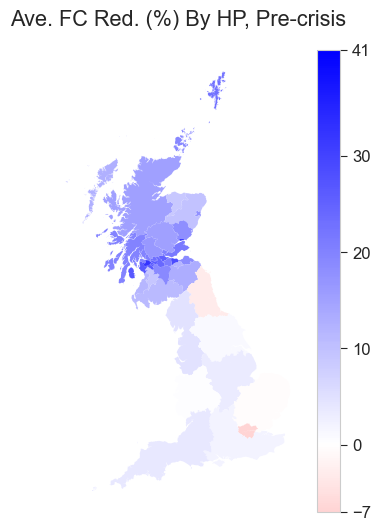

In [12]:
fig, ax = plt.subplots(figsize = [4,6])

price_year = 2019
########################

map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(df_cost_re_all[price_year].reset_index(drop=True))

vmin, vmax = 0.5*min(df_cost_re_all[price_year].values).item(), max(df_cost_re_all[price_year].values).item()
vmin, vmax = -7, 41
# cmap = "RdBu"
cmap = "bwr_r"
# cmap = "seismic_r"

# get truncated colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap(cmap)
new_cmap = truncate_colormap(cmap, 0.5+(vmin / vmax * 0.5), 1)

map_and_res_df.plot(column="cost re", cmap=new_cmap, ax = ax, legend=False, vmin =vmin, vmax = vmax, linewidth = 0, rasterized=True)

# Create a ScalarMappable object
sm = cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Set an empty array to ensure proper mapping

# Add colorbar with ticks
cbar = plt.colorbar(sm)
cbar.set_ticks([-7, 0, 10, 20, 30, 41])  # Set the ticks to the extreme values

ax.axis("off")
ax.set_title(f"Ave. FC Red. (%) By HP, {year_dict[price_year]}")


del map_and_res_df

# plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", f"cost_diff_geomap_{price_year}.pdf"), dpi = 3000)
plt.show()

### Year 2022

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_884188\3104019082.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


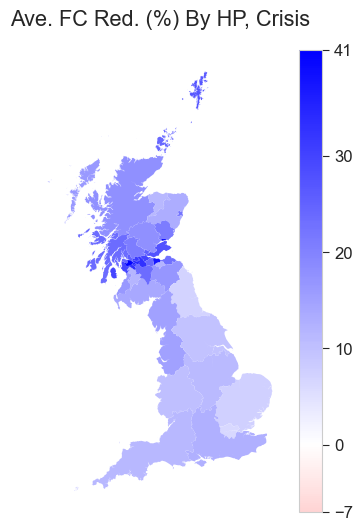

In [13]:
fig, ax = plt.subplots(figsize = [4,6])

price_year = 2022
########################

map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(df_cost_re_all[price_year].reset_index(drop=True))

vmin, vmax = 0.5*min(df_cost_re_all[price_year].values).item(), max(df_cost_re_all[price_year].values).item()
vmin, vmax = -7, 41
# cmap = "RdBu"
cmap = "bwr_r"
# cmap = "seismic_r"

# get truncated colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap(cmap)
new_cmap = truncate_colormap(cmap, 0.5+(vmin / vmax * 0.5), 1)

map_and_res_df.plot(column="cost re", cmap=new_cmap, ax = ax, legend=False, vmin =vmin, vmax = vmax, linewidth = 0, rasterized=True)

# Create a ScalarMappable object
sm = cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Set an empty array to ensure proper mapping

# Add colorbar with ticks
cbar = plt.colorbar(sm)
cbar.set_ticks([-7, 0, 10, 20, 30, 41])  # Set the ticks to the extreme values

ax.axis("off")
ax.set_title(f"Ave. FC Red. (%) By HP, {year_dict[price_year]}")


del map_and_res_df

# plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", f"cost_diff_geomap_{price_year}.pdf"), dpi = 3000)
plt.show()

In [14]:
df_cost_re_all[2019]

,cost re
0,20.261502
1,10.857421
2,8.987070
3,18.602936
4,26.049159
5,12.635714
6,25.316153
7,15.129155
8,20.041346
9,12.009343


In [15]:
df_cost_re_all[2019]["RegCode"] = map_df["RegID"].copy()
df_cost_re_all[2019]["RegName"] = map_df["RegName"].copy()
df_cost_re_all[2022]["RegCode"] = map_df["RegID"].copy()
df_cost_re_all[2022]["RegName"] = map_df["RegName"].copy()

In [16]:
(df_cost_re_all[price_year].min(), df_cost_re_all[price_year].max())

(cost re         6.243194
 RegCode        E12000001
 RegName    Aberdeen City
 dtype: object,
 cost re                   40.648556
 RegCode                   S12000050
 RegName    Yorkshire and The Humber
 dtype: object)

In [17]:
df_cost_re_all[price_year]

,cost re,RegCode,RegName
0,25.610911,S12000005,Clackmannanshire
1,13.841121,S12000006,Dumfries and Galloway
2,11.774460,S12000008,East Ayrshire
3,23.036420,S12000010,East Lothian
4,33.097454,S12000011,East Renfrewshire
5,16.344846,S12000013,Na h-Eileanan Siar
6,30.009576,S12000014,Falkirk
7,17.782176,S12000017,Highland
8,23.970348,S12000018,Inverclyde
9,12.019035,S12000019,Midlothian


C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_884188\553328684.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


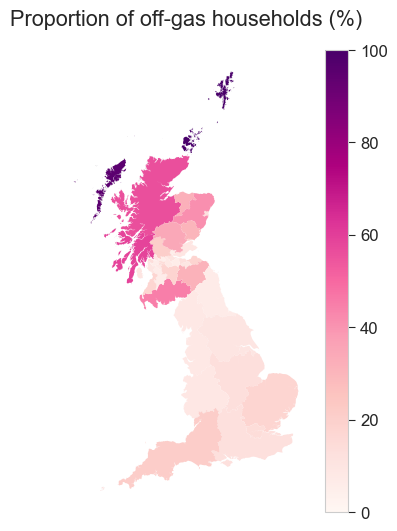

In [18]:
### plot off gas rate
from matplotlib.colors import ListedColormap

All_nongas_res_dict = np.load(os.path.join(os.getcwd(), "data_for_plot", "All_nongas_res_dict.npy"), allow_pickle=True).item()
nongasrate_df = ordering_fp_res_as_mapdf(map_df, All_nongas_res_dict) * 100

map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(nongasrate_df.reset_index(drop=True))

fig, ax = plt.subplots(figsize = [4, 6])

cmap = "viridis_r"
cmap = "RdPu"

vmin, vmax = 0, 100
map_and_res_df.plot(column="fp_rate", cmap=cmap, ax = ax, legend=False, vmin =vmin, vmax = vmax, linewidth = 0, rasterized=True)

# Create a ScalarMappable object
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Set an empty array to ensure proper mapping

# Add colorbar with ticks
cbar = plt.colorbar(sm)
cbar.set_ticks([0, 20, 40, 60, 80, 100])  # Set the ticks to the extreme values

ax.axis("off")
plt.title(f"Proportion of off-gas households (%)")
plt.savefig(os.path.join(os.getcwd(), "figures", f"Offgas_rate.pdf"), dpi = 3000)
plt.show()

del map_and_res_df

In [19]:
vmin, vmax

(0, 100)

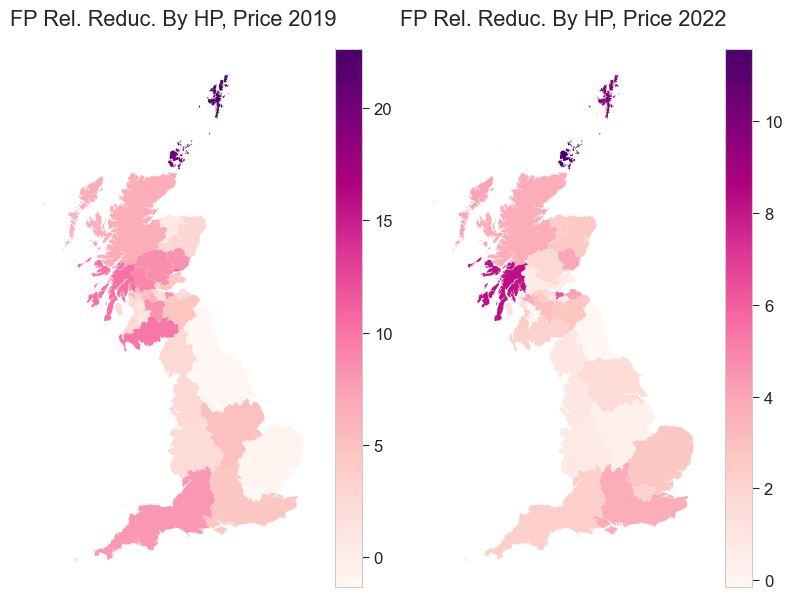

In [20]:
# specify show absolute or relative difference
Absolute_diff = False

fig, (ax1, ax2) = plt.subplots(1,2,figsize = [8,6])

########################

if Absolute_diff:
    fp_diff_df_2019 = pd.DataFrame(data = fp_res_df_2019.values - fp_res_HP_df_2019.values, columns = ["fp_diff"])
else:
    fp_diff_df_2019 = pd.DataFrame(data = 100*(fp_res_df_2019.values - fp_res_HP_df_2019.values) / fp_res_df_2019.values, columns = ["fp_diff"])

map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(fp_diff_df_2019.reset_index(drop=True))

vmin, vmax = 0.5*min(fp_diff_df_2019.values), max(fp_diff_df_2019.values)

map_and_res_df.plot(column="fp_diff", cmap=cmap, ax = ax1, legend=True, vmin =vmin, vmax = vmax, linewidth = 0)
ax1.axis("off")
ax1.set_title(f"FP {'Abs.' if Absolute_diff else 'Rel.'} Reduc. By HP, Price 2019")

del map_and_res_df
fp_diff_df_2019["RegName"] = map_df["RegName"].copy()
fp_diff_df_2019["RegCode"] = map_df["RegID"].copy()

########################

if Absolute_diff:
    fp_diff_df_2022 = pd.DataFrame(data = fp_res_df_2022.values - fp_res_HP_df_2022.values, columns = ["fp_diff"])
else:
    fp_diff_df_2022 = pd.DataFrame(data = 100*(fp_res_df_2022.values - fp_res_HP_df_2022.values) / fp_res_df_2022.values, columns = ["fp_diff"])

map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(fp_diff_df_2022.reset_index(drop=True))

vmin, vmax = 0.5*min(fp_diff_df_2022.values), max(fp_diff_df_2022.values)

map_and_res_df.plot(column="fp_diff", cmap=cmap, ax = ax2, legend=True, vmin =vmin, vmax = vmax, linewidth = 0)
ax2.axis("off")
ax2.set_title(f"FP {'Abs.' if Absolute_diff else 'Rel.'} Reduc. By HP, Price 2022")

plt.tight_layout()
plt.savefig(os.path.join(os.getcwd(), "figures", f"fp_diff_geomap.png"), dpi = 300)
plt.show()

del map_and_res_df
fp_diff_df_2022["RegName"] = map_df["RegName"].copy()
fp_diff_df_2022["RegCode"] = map_df["RegID"].copy()


fp_diff_df_dict = {2019:fp_diff_df_2019, 2022:fp_diff_df_2022}

# Plots with Network Upgrade Cost

In [21]:
network_root_path = os.path.join(root_path, "UKM_PrimarySubstation_Data")
upgrade_cost_df = pd.read_csv(os.path.join(network_root_path, "reg_upgrade_cost.csv"))

reg2totcost = {upgrade_cost_df.iloc[i]["RegCode"]:upgrade_cost_df.iloc[i]["Upgrade Cost (M£)"] for i in range(len(upgrade_cost_df))}
reg2avecost = {upgrade_cost_df.iloc[i]["RegCode"]:upgrade_cost_df.iloc[i]["Upgrade Cost (M£)"]/upgrade_cost_df.iloc[i]["Number of PS"] for i in range(len(upgrade_cost_df))}

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_884188\2335356488.py:16: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


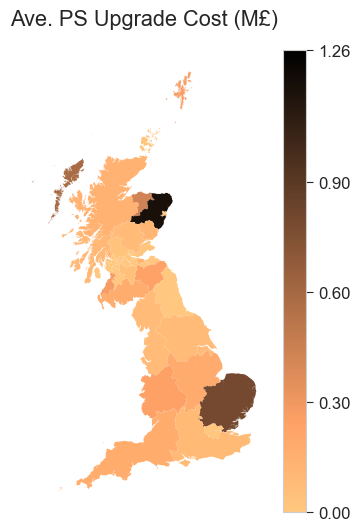

In [22]:
avecost_df = pd.DataFrame(data = map_df["RegID"].map(reg2avecost).values, columns=["Ave Upgrade Cost"])
map_and_res_df = map_df.join(avecost_df.reset_index(drop=True))

vmin, vmax = 0.5*min(avecost_df.values), max(avecost_df.values)
vmin, vmax = 0, 1.26

fig, ax = plt.subplots(figsize = [4, 6])
cmap = "copper_r"
map_and_res_df.plot(column="Ave Upgrade Cost", cmap=cmap, ax = ax, legend=False, vmin =vmin, vmax = vmax, linewidth = 0, rasterized=True)

# Create a ScalarMappable object
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Set an empty array to ensure proper mapping

# Add colorbar with ticks
cbar = plt.colorbar(sm)
cbar.set_ticks([0, 0.3, .6, .9, 1.26])  # Set the ticks to the extreme values

ax.axis("off")
plt.title(f"Ave. PS Upgrade Cost (M£)")

plt.savefig(os.path.join(os.getcwd(), "figures", f"cost_geomap.pdf"), dpi = 3000)
plt.show()

del map_and_res_df

In [23]:
vmin, vmax

(0, 1.26)

## Combine GHG Emission, FP, and upgrade cost

In [24]:
for key in fp_diff_df_dict.keys():
    fp_diff_df_dict[key]["Ave Upgrade Cost (M£)"] = fp_diff_df_dict[key]["RegCode"].map(reg2avecost)


In [25]:
GHG_reduction_rate_dict = np.load(os.path.join(root_path, "GHG_reduction_rate_dict.npy"), allow_pickle=True).item()
GHG_reduction_rate_dict["City of Edinburgh"] = GHG_reduction_rate_dict.pop("Edinburgh, City of")
GHG_reduction_rate_dict["Yorkshire and The Humber"] = GHG_reduction_rate_dict.pop("Yorkshire and the Humber")
GHG_reduction_rate_dict["East of England"] = GHG_reduction_rate_dict.pop("East")

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_884188\471019803.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap('Greens')
C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_884188\471019803.py:27: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


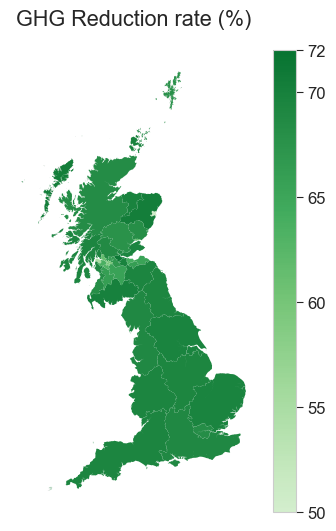

In [26]:
### plot GHG reduction
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors

GHGreduc_df = ordering_fp_res_as_mapdf(map_df, GHG_reduction_rate_dict) * 100

map_df = map_df.reset_index(drop=True)
map_and_res_df = map_df.join(GHGreduc_df.reset_index(drop=True))

fig, ax = plt.subplots(figsize = [4, 6])

original_cmap = plt.cm.get_cmap('Greens')
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "trunc({n},{a:.2f},{b:.2f})".format(n=original_cmap.name, a=0.2, b=0.85),
    original_cmap(np.linspace(0.2, 0.85, 256))
)

vmin, vmax = GHGreduc_df.min(), GHGreduc_df.max()
vmin, vmax = 50, 72
map_and_res_df.plot(column="fp_rate", cmap=new_cmap, ax = ax, legend=False, vmin =vmin, vmax = vmax, linewidth = 0, rasterized=True)

# Create a ScalarMappable object
sm = cm.ScalarMappable(cmap=new_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # Set an empty array to ensure proper mapping

# Add colorbar with ticks
cbar = plt.colorbar(sm)
cbar.set_ticks([50, 55, 60, 65, 70, 72])  # Set the ticks to the extreme values

ax.axis("off")
plt.title(f"GHG Reduction rate (%)")
plt.savefig(os.path.join(os.getcwd(), "figures", f"GHGreduc_rate.pdf"), dpi = 3000)
plt.show()

del map_and_res_df

In [24]:
vmin, vmax

(50, 72)

## FP red, GHG red, vs upgrade cost
### Year 2019

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_182088\2251941188.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap('Greens')


The pearson corr is -0.07250922473210838


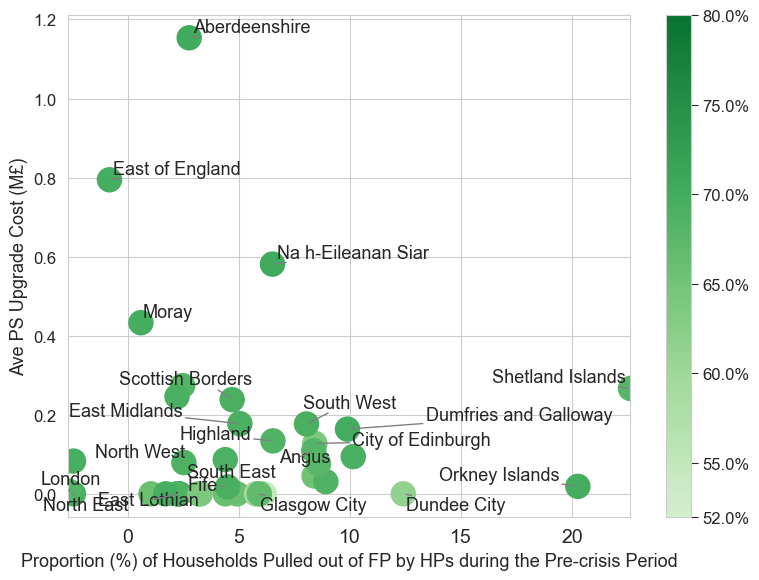

In [25]:
price_year = 2019
fp_diff_df_dict[price_year]["GHG Reduc. Rate"] = fp_diff_df_dict[price_year]["RegName"].map(GHG_reduction_rate_dict)*100

log_scale = False

fig, ax = plt.subplots(figsize=[8,6])

original_cmap = plt.cm.get_cmap('Greens')
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "trunc({n},{a:.2f},{b:.2f})".format(n=original_cmap.name, a=0.2, b=0.85),
    original_cmap(np.linspace(0.2, 0.85, 256))
)

sc = plt.scatter(fp_diff_df_dict[price_year]['fp_diff'], fp_diff_df_dict[price_year]['Ave Upgrade Cost (M£)'], s = 300, c = fp_diff_df_dict[price_year]["GHG Reduc. Rate"].values, cmap = new_cmap, vmin = 52, vmax = 80)
cbar = plt.colorbar(sc, format=mticker.PercentFormatter())
ticks = [52, 55, 60, 65, 70, 75, 80]
cbar.set_ticks(ticks)  # Set the ticks to the extreme values

xmax = fp_diff_df_dict[2019]["fp_diff"].max()
xmin = fp_diff_df_dict[2019]["fp_diff"].min()

ymax = fp_diff_df_dict[price_year]["Ave Upgrade Cost (M£)"].max()
ymin = fp_diff_df_dict[price_year]["Ave Upgrade Cost (M£)"].min()

year_dict = {2019: 'during the Pre-crisis Period',
             2022: 'during the Energy Crisis'}
# plt.title('Cost vs Benefits')
# Set x-axis label
plt.xlabel(f'Proportion (%) of Households Pulled out of FP by HPs {year_dict[price_year]}')
# Set y-axis label
plt.ylabel('Ave PS Upgrade Cost (M£)')
plt.grid()

from adjustText import adjust_text
# ax = plt.gca()
a = pd.concat({'x': fp_diff_df_dict[price_year]["fp_diff"], 'y': fp_diff_df_dict[price_year]["Ave Upgrade Cost (M£)"], 'val': fp_diff_df_dict[price_year]["RegName"]}, axis=1)

# Hide specific text labels
# texts_to_hide = ['Inverclyde', 'Renfrewshire', 'East Dunbartonshire',
#                  'Perth and Kinross', 'Argyll and Bute', 'North Lanarkshire',
#                  'Clackmannanshire', 'South Lanarkshire', 'Falkirk', "East Renfrewshire", "Midlothian",
#                  "West Midlands", "South Ayrshire", "Na h-Eileanan Siar", "South Lanarkshire", 'West Dunbartonshire',
#                  'Aberdeenshire', 'Dumfries and Galloway', 'East Midlands', 'North Ayrshire']

texts_to_hide = ['Inverclyde', 'Renfrewshire', 'East Dunbartonshire', 'West Lothian', 'Aberdeen City',
                 'Perth and Kinross', 'Argyll and Bute', 'North Lanarkshire',
                 'Clackmannanshire', 'South Lanarkshire', 'Falkirk', "East Renfrewshire", "Midlothian",
                 "West Midlands", "South Ayrshire", "South Lanarkshire", 'East Ayrshire',
                 'North Ayrshire', "Yorkshire and The Humber", 'West Dunbartonshire', 'Stirling']


if log_scale:
    ax.set_yscale('symlog', linthresh = 2e-2)
    ax.set_xscale('symlog', linthresh = 1e0)
    texts = [ax.text(point['x'], point['y'], str(point['val'])) for i, point in a.iterrows() if str(point['val']) not in texts_to_hide]
else:
    texts = [ax.text(point['x'], point['y'], str(point['val'])) for i, point in a.iterrows() if str(point['val']) not in texts_to_hide]


adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey'))

plt.xlim([xmin, xmax])
# plt.ylim([ymin, ymax])

corr = np.corrcoef(fp_diff_df_dict[price_year]["fp_diff"], fp_diff_df_dict[price_year]["Ave Upgrade Cost (M£)"])[0,1]
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(os.getcwd(), "figures", f"cost_benefits_{price_year}.pdf"), dpi = 300)
print(f"The pearson corr is {corr}")

In [26]:
fp_diff_df_dict[2019]

,fp_diff,RegName,RegCode,Ave Upgrade Cost (M£),GHG Reduc. Rate
0,3.183222,Clackmannanshire,S12000005,0.000000,68.632081
1,9.881026,Dumfries and Galloway,S12000006,0.163740,69.985378
2,1.031509,East Ayrshire,S12000008,0.000000,66.055647
3,2.319764,East Lothian,S12000010,0.000000,65.340156
4,2.210862,East Renfrewshire,S12000011,0.000000,63.040039
5,6.503059,Na h-Eileanan Siar,S12000013,0.581149,70.402460
6,2.281408,Falkirk,S12000014,0.000000,71.272615
7,6.524852,Highland,S12000017,0.133953,68.469148
8,6.126942,Inverclyde,S12000018,0.000000,54.732550
9,4.381769,Midlothian,S12000019,0.000000,66.047696


### Year 2022

C:\Users\Zhou_Ming\AppData\Local\Temp\ipykernel_182088\2126506812.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap('Greens')


The pearson corr is 0.10508886676271072


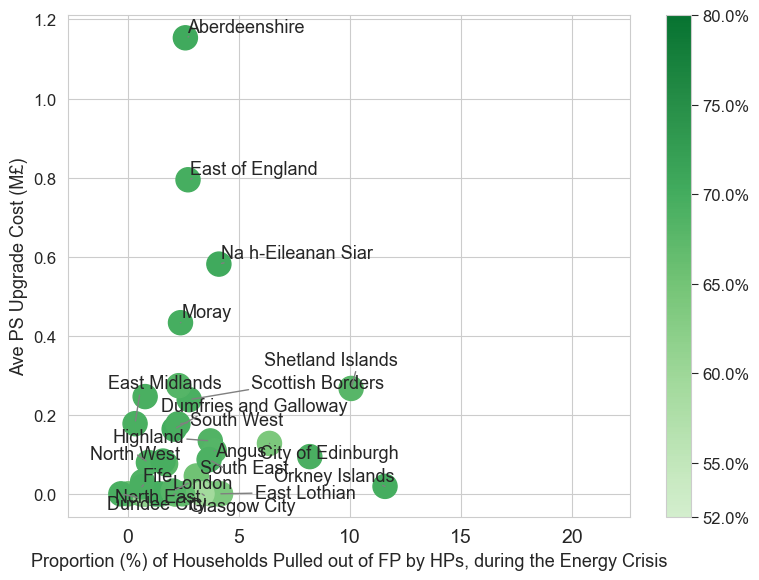

In [27]:
price_year = 2022
fp_diff_df_dict[price_year]["GHG Reduc. Rate"] = fp_diff_df_dict[price_year]["RegName"].map(GHG_reduction_rate_dict)*100

log_scale = False

fig, ax = plt.subplots(figsize=[8,6])

original_cmap = plt.cm.get_cmap('Greens')
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "trunc({n},{a:.2f},{b:.2f})".format(n=original_cmap.name, a=0.2, b=0.85),
    original_cmap(np.linspace(0.2, 0.85, 256))
)

sc = plt.scatter(fp_diff_df_dict[price_year]['fp_diff'], fp_diff_df_dict[price_year]['Ave Upgrade Cost (M£)'], s = 300, c = fp_diff_df_dict[price_year]["GHG Reduc. Rate"].values, cmap = new_cmap, vmin = 52, vmax = 80)
cbar = plt.colorbar(sc, format=mticker.PercentFormatter())
ticks = [52, 55, 60, 65, 70, 75, 80]
cbar.set_ticks(ticks)  # Set the ticks to the extreme values

xmax = fp_diff_df_dict[2019]["fp_diff"].max()
xmin = fp_diff_df_dict[2019]["fp_diff"].min()

ymax = fp_diff_df_dict[price_year]["Ave Upgrade Cost (M£)"].max()
ymin = fp_diff_df_dict[price_year]["Ave Upgrade Cost (M£)"].min()

# plt.title('Cost vs Benefits')
# Set x-axis label
plt.xlabel(f'Proportion (%) of Households Pulled out of FP by HPs, {year_dict[price_year]}')
# Set y-axis label
plt.ylabel('Ave PS Upgrade Cost (M£)')
plt.grid()

from adjustText import adjust_text
# ax = plt.gca()
a = pd.concat({'x': fp_diff_df_dict[price_year]["fp_diff"], 'y': fp_diff_df_dict[price_year]["Ave Upgrade Cost (M£)"], 'val': fp_diff_df_dict[price_year]["RegName"]}, axis=1)

# Hide specific text labels
# texts_to_hide = ['Inverclyde', 'Renfrewshire', 'East Dunbartonshire',
#                  'Perth and Kinross', 'Argyll and Bute', 'North Lanarkshire',
#                  'Clackmannanshire', 'South Lanarkshire', 'Falkirk', "East Renfrewshire", "Midlothian",
#                  "West Midlands", "South Ayrshire", "Na h-Eileanan Siar", "South Lanarkshire", 'West Dunbartonshire',
#                  'Aberdeenshire', 'Dumfries and Galloway', 'East Midlands', 'North Ayrshire']

texts_to_hide = ['Inverclyde', 'Renfrewshire', 'East Dunbartonshire', 'West Lothian', 'Aberdeen City',
                 'Perth and Kinross', 'Argyll and Bute', 'North Lanarkshire',
                 'Clackmannanshire', 'South Lanarkshire', 'Falkirk', "East Renfrewshire", "Midlothian",
                 "West Midlands", "South Ayrshire", "South Lanarkshire", 'East Ayrshire',
                 'North Ayrshire', "Yorkshire and The Humber", 'West Dunbartonshire', 'Stirling']


if log_scale:
    ax.set_yscale('symlog', linthresh = 2e-2)
    ax.set_xscale('symlog', linthresh = 1e0)
    texts = [ax.text(point['x'], point['y'], str(point['val'])) for i, point in a.iterrows() if str(point['val']) not in texts_to_hide]
else:
    texts = [ax.text(point['x'], point['y'], str(point['val'])) for i, point in a.iterrows() if str(point['val']) not in texts_to_hide]


adjust_text(texts, arrowprops=dict(arrowstyle='-', color='grey'))

plt.xlim([xmin, xmax])
# plt.ylim([ymin, ymax])

corr = np.corrcoef(fp_diff_df_dict[price_year]["fp_diff"], fp_diff_df_dict[price_year]["Ave Upgrade Cost (M£)"])[0,1]
plt.tight_layout()
plt.grid()
plt.savefig(os.path.join(os.getcwd(), "figures", f"cost_benefits_{price_year}.pdf"), dpi = 300)
print(f"The pearson corr is {corr}")

# Correlation plot

In [28]:
AllRes_df = fp_diff_df_dict[2019].copy()
AllRes_df.rename(columns={"fp_diff":"fp reduc normal"}, inplace=True)
AllRes_df["fp reduc crisis"] = fp_diff_df_dict[2022]["fp_diff"].copy().values
AllRes_df["offgas rate"] = nongasrate_df["fp_rate"].values
AllRes_df["fp normal"] = fp_res_df_dict[2019]["fp_rate"].values
AllRes_df["fp crisis"] = fp_res_df_dict[2022]["fp_rate"].values
AllRes_df["cost reduc normal"] = df_cost_re_all[2019]['cost re'].values
AllRes_df["cost reduc crisis"] = df_cost_re_all[2022]['cost re'].values
AllRes_df

,fp reduc normal,RegName,RegCode,Ave Upgrade Cost (M£),GHG Reduc. Rate,fp reduc crisis,offgas rate,fp normal,fp crisis,cost reduc normal,cost reduc crisis
0,3.183222,Clackmannanshire,S12000005,0.000000,68.632081,0.792698,5.712960,30.263506,61.854200,20.261502,25.610911
1,9.881026,Dumfries and Galloway,S12000006,0.163740,69.985378,2.075680,45.093869,53.742928,81.073051,10.857421,13.841121
2,1.031509,East Ayrshire,S12000008,0.000000,66.055647,0.000000,6.178989,41.370079,78.808132,8.987070,11.774460
3,2.319764,East Lothian,S12000010,0.000000,65.340156,4.055667,18.082768,33.005720,63.870923,18.602936,23.036420
4,2.210862,East Renfrewshire,S12000011,0.000000,63.040039,3.713985,7.495965,27.131766,64.844533,26.049159,33.097454
5,6.503059,Na h-Eileanan Siar,S12000013,0.581149,70.402460,4.089650,95.179266,72.701120,94.710026,12.635714,16.344846
6,2.281408,Falkirk,S12000014,0.000000,71.272615,1.510433,10.879703,33.972982,61.884123,25.316153,30.009576
7,6.524852,Highland,S12000017,0.133953,68.469148,3.702746,56.146176,58.465697,83.017572,15.129155,17.782176
8,6.126942,Inverclyde,S12000018,0.000000,54.732550,0.679978,13.937206,38.027010,65.762126,20.041346,23.970348
9,4.381769,Midlothian,S12000019,0.000000,66.047696,0.581125,9.405203,30.667460,61.111437,12.009343,12.019035


In [29]:
from scipy.stats import spearmanr, pearsonr, kendalltau

data = AllRes_df[["fp normal", "fp crisis", "fp reduc normal", "fp reduc crisis", "GHG Reduc. Rate", "offgas rate", "Ave Upgrade Cost (M£)"]].copy()
data.rename(columns={"fp normal":"fp pre-crisis", "Ave Upgrade Cost (M£)":"Ave Upg. Cost", "offgas rate":"offgas proportion", "fp reduc normal": "fp reduc pre-crisis"}, inplace=True)
def corrfunc_pear(x, y, **kws):
    r, _ = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("pr = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

def corrfunc_spear(x, y, **kws):
    r, _ = spearmanr(x, y)
    ax = plt.gca()
    ax.annotate("spr = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)



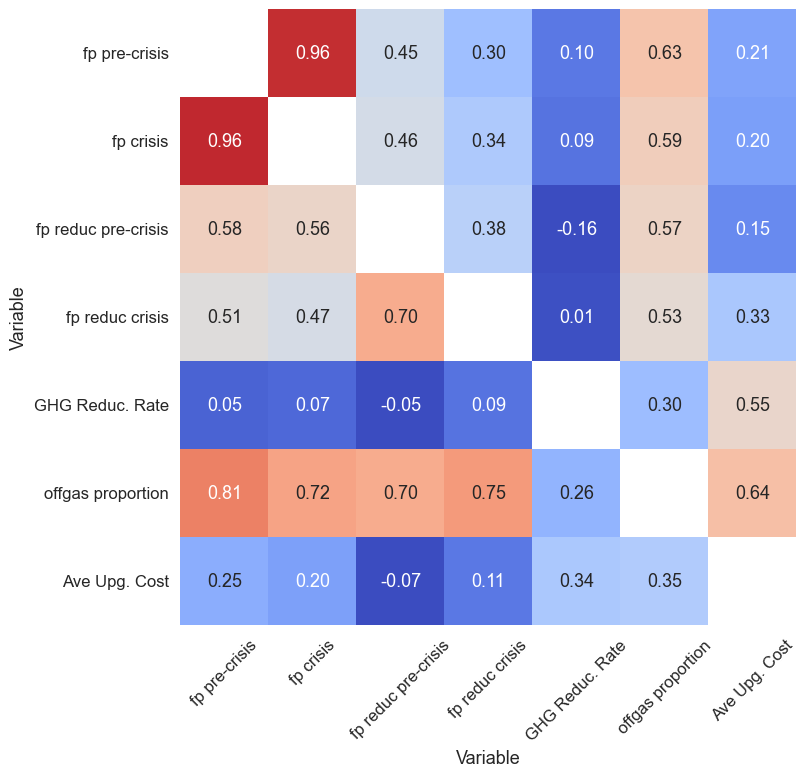

In [30]:
### The correlation is the absolute value
from matplotlib import rcParams
# Set up the aesthetics for the plot
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

# Calculate the Pearson correlation for the lower triangle
pearson_corr = data.corr(method='pearson')
mask_pearson = np.triu(np.ones_like(pearson_corr, dtype=bool))
pearson_corr[mask_pearson] = 0

# Calculate the Spearman correlation for the upper triangle
spearman_corr = data.corr(method='spearman')
mask_spearman = np.tril(np.ones_like(spearman_corr, dtype=bool))
spearman_corr[mask_spearman] = 0

# Combine the two correlation matrices
combined_corr = pearson_corr + spearman_corr

# Set the diagonal elements to None (or any other value you prefer)
np.fill_diagonal(combined_corr.values, None)

# Create the correlation heatmap using Seaborn
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(combined_corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=0, vmax=1, square=True, cbar=False, ax=ax)
# ax.set_title("Combined Correlation Heatmap", fontsize=16, fontweight='bold')

# Set axis labels
ax.set_xlabel("Variable")
ax.set_ylabel("Variable")

plt.xticks(rotation = 45)
# turn off grid
ax.grid(False)
# Save the figure in a high-resolution format
plt.savefig(os.path.join(os.getcwd(), "figures", 'combined_correlation_heatmap.pdf'), format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# All_elec_res_dict = np.load(os.path.join(os.getcwd(), "data_for_plot", "All_elec_res_dict.npy"), allow_pickle=True).item()
# data["elec rate"] = AllRes_df["RegCode"].map(All_elec_res_dict).copy()
# data["elec2offgas"] = data["elec rate"] / data["offgas rate"]
#
# # Calculate the Pearson correlation for the lower triangle
# pearson_corr = data.corr(method='pearson')
# mask_pearson = np.triu(np.ones_like(pearson_corr, dtype=bool))
# pearson_corr[mask_pearson] = 0
#
# # Calculate the Spearman correlation for the upper triangle
# spearman_corr = data.corr(method='spearman')
# mask_spearman = np.tril(np.ones_like(spearman_corr, dtype=bool))
# spearman_corr[mask_spearman] = 0
#
# # Combine the two correlation matrices
# combined_corr = pearson_corr + spearman_corr
#
# # Set the diagonal elements to None (or any other value you prefer)
# np.fill_diagonal(combined_corr.values, None)
#
# # Create the correlation heatmap using Seaborn
# fig, ax = plt.subplots(figsize=(8, 8))
# sns.heatmap(combined_corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=0, vmax=1, square=True, cbar=False, ax=ax)
# ax.set_title("Combined Correlation Heatmap", fontsize=16, fontweight='bold')
#
# # Set axis labels
# ax.set_xlabel("Variable")
# ax.set_ylabel("Variable")
#
# plt.xticks(rotation = 45)

In [32]:
data

,fp pre-crisis,fp crisis,fp reduc pre-crisis,fp reduc crisis,GHG Reduc. Rate,offgas proportion,Ave Upg. Cost
0,30.263506,61.854200,3.183222,0.792698,68.632081,5.712960,0.000000
1,53.742928,81.073051,9.881026,2.075680,69.985378,45.093869,0.163740
2,41.370079,78.808132,1.031509,0.000000,66.055647,6.178989,0.000000
3,33.005720,63.870923,2.319764,4.055667,65.340156,18.082768,0.000000
4,27.131766,64.844533,2.210862,3.713985,63.040039,7.495965,0.000000
5,72.701120,94.710026,6.503059,4.089650,70.402460,95.179266,0.581149
6,33.972982,61.884123,2.281408,1.510433,71.272615,10.879703,0.000000
7,58.465697,83.017572,6.524852,3.702746,68.469148,56.146176,0.133953
8,38.027010,65.762126,6.126942,0.679978,54.732550,13.937206,0.000000
9,30.667460,61.111437,4.381769,0.581125,66.047696,9.405203,0.000000


In [33]:
AllRes_df

,fp reduc normal,RegName,RegCode,Ave Upgrade Cost (M£),GHG Reduc. Rate,fp reduc crisis,offgas rate,fp normal,fp crisis,cost reduc normal,cost reduc crisis
0,3.183222,Clackmannanshire,S12000005,0.000000,68.632081,0.792698,5.712960,30.263506,61.854200,20.261502,25.610911
1,9.881026,Dumfries and Galloway,S12000006,0.163740,69.985378,2.075680,45.093869,53.742928,81.073051,10.857421,13.841121
2,1.031509,East Ayrshire,S12000008,0.000000,66.055647,0.000000,6.178989,41.370079,78.808132,8.987070,11.774460
3,2.319764,East Lothian,S12000010,0.000000,65.340156,4.055667,18.082768,33.005720,63.870923,18.602936,23.036420
4,2.210862,East Renfrewshire,S12000011,0.000000,63.040039,3.713985,7.495965,27.131766,64.844533,26.049159,33.097454
5,6.503059,Na h-Eileanan Siar,S12000013,0.581149,70.402460,4.089650,95.179266,72.701120,94.710026,12.635714,16.344846
6,2.281408,Falkirk,S12000014,0.000000,71.272615,1.510433,10.879703,33.972982,61.884123,25.316153,30.009576
7,6.524852,Highland,S12000017,0.133953,68.469148,3.702746,56.146176,58.465697,83.017572,15.129155,17.782176
8,6.126942,Inverclyde,S12000018,0.000000,54.732550,0.679978,13.937206,38.027010,65.762126,20.041346,23.970348
9,4.381769,Midlothian,S12000019,0.000000,66.047696,0.581125,9.405203,30.667460,61.111437,12.009343,12.019035
